In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

In [ ]:
# ---- Sampling layer (re-using your logic) ----
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z."""
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return epsilon * tf.exp(0.5 * log_var) + mean

latent_dim = 2

In [ ]:
 encoder_inputs = keras.Input(shape=(28, 28, 1))
 x=layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
 x=layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
 x=layers.Flatten()(x)
 x=layers.Dense(16, activation="relu")(x)
 mean = layers.Dense(latent_dim, name="mean")(x)
 log_var = layers.Dense(latent_dim, name="log_var")(x)
 z = Sampling()([mean, log_var])
 encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
 encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │    100,368 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log_var (Dense)     │ (None, 2)         │         34 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ mean[0][0],       │
│                     │                   │            │ log_var[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 174,932 (683.33 KB)

 Trainable params: 174,932 (683.33 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,633 (615.75 KB)

 Trainable params: 157,633 (615.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ---- Custom VAE model ----
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        if isinstance(data, tuple):  # (x, y) or (x, _)
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data, training=True)
            reconstruction = self.decoder(z, training=True)

            # Reconstruction loss: sum over pixels, mean over batch
            bce = keras.losses.binary_crossentropy(data, reconstruction)
            # binary_crossentropy returns per-pixel loss; reduce over H and W
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(bce, axis=(1, 2)))

            # KL divergence loss: mean over batch, sum over latent dims
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.exp(z_log_var) - tf.square(z_mean), axis=1)
            )

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
(x_train,_),(x_test,_) = keras.datasets.fashion_mnist.load_data()
fashion_mnist=np.concatenate([x_train,x_test],axis=0)
fashion_mnist = np.expand_dims(x_train, -1).astype("float32") / 255.0

vae=VAE(encoder,decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(fashion_mnist,epochs=3,batch_size=128)

Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 248s 519ms/step - kl_loss: 4.7967 - loss: 381.4481 - reconstruction_loss: 376.6514
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 239s 510ms/step - kl_loss: 8.4807 - loss: 286.0513 - reconstruction_loss: 277.5706
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 257s 501ms/step - kl_loss: 7.4765 - loss: 275.3400 - reconstruction_loss: 267.8634


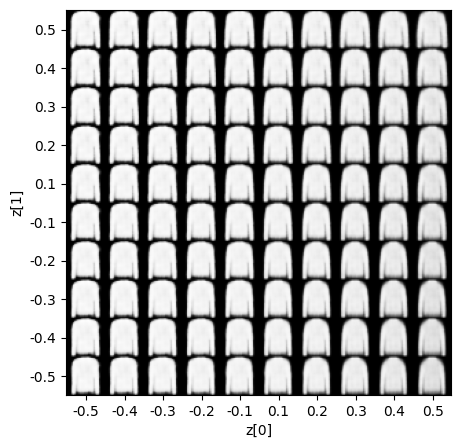

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=10, figsize=5):
    img_size = 28
    scale = 0.5
    figure = np.zeros((img_size * n, img_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(sample, verbose=0)
            images = x_decoded[0].reshape(img_size, img_size)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = images

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step


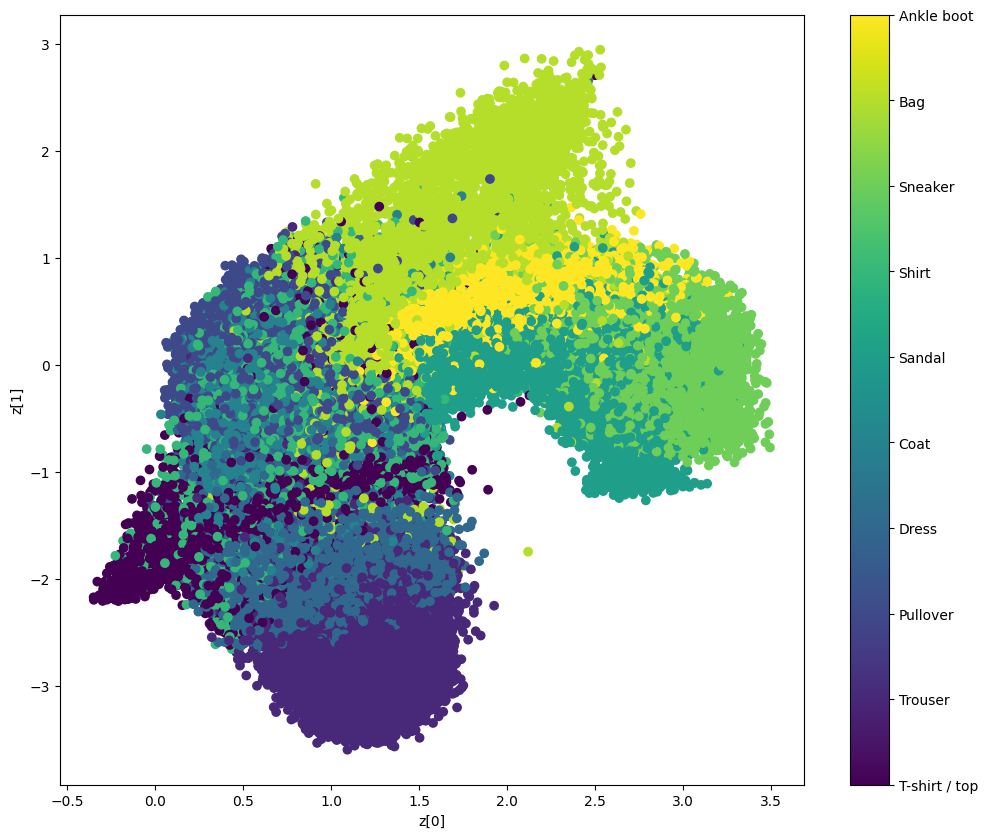

In [ ]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=test_lab)
    cbar = plt.colorbar(sc, ticks=range(10))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

labels = {
    0: "T-shirt / top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)
